In [70]:
%matplotlib inline
import pandas as pd
import numpy as np

import time
import matplotlib.pyplot as plt
import cantera as ct
print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 3.0.0


**part III - Explosion Theory**

Computed Ignition Delay: 2.845e+00 seconds. Took 1.31s to compute


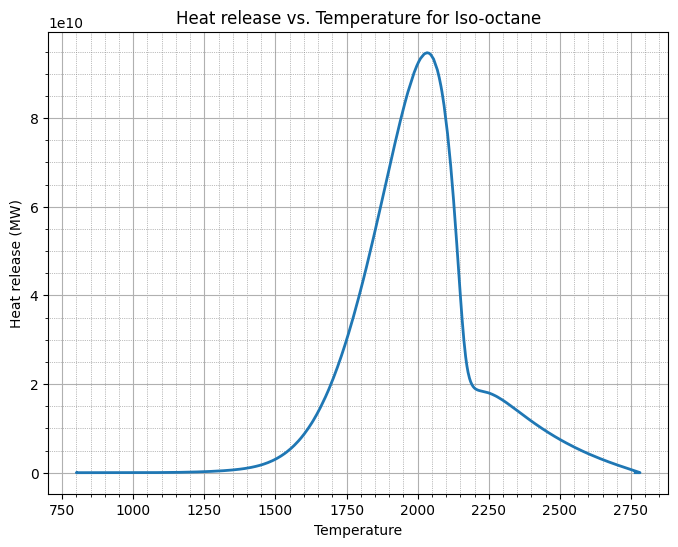

In [112]:
# DEFINING THE CONSTANTS AND VARIAABLES TO STORE -----------------------------------------------------
# Constants
r = 0.037  # Radius in meters
Tin = 800  # Initial temperature in K
P = 101325  # Initial pressure in Pa

phi = 1  # stoichemetric ratio

# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
#gas = ct.Solution('gri30.yaml')
gas.TP = Tin, P
# for methane -----------------------------------------------
#gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')
#gas.set_equivalence_ratio(phi, 'H2', 'O2:0.5, N2:1.88')
# for iso-octane --------------------------------------------
gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:12.5, N2:47')

# Calculate the volume and surface area of the reactor
volume = (4/3) * np.pi * r**3
surface_area = 4 * np.pi * r**2

# Create an ideal gas reactor
#reactor = ct.IdealGasReactor(gas, volume=volume)
reactor = ct.IdealGasReactor(gas, volume=volume)
simulation=ct.ReactorNet([reactor])


time_history = ct.SolutionArray(gas, extra="t")
# CALCULATION OF IGINITION DELAY
import time

def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]
reference_species = "oh"

# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay = 5 # Initial guess for ignition delay in seconds
t = 0

counter = 1
while t < estimated_ignition_delay:
    t = simulation.step()
    if not counter % 10:
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(reactor.thermo.state, t=t)
    counter += 1

# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)

# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")

plt.figure(figsize=(8, 6))
plt.plot( time_history.T, time_history.heat_release_rate, lw = '2', label = 'iso-octane')
#plt.plot( temperature_history, heat_release_storage_methane, lw = '2', label = 'methane')
plt.xlabel('Temperature')
plt.ylabel('Heat release (MW)')
plt.title('Heat release vs. Temperature for Iso-octane')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()
#print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")

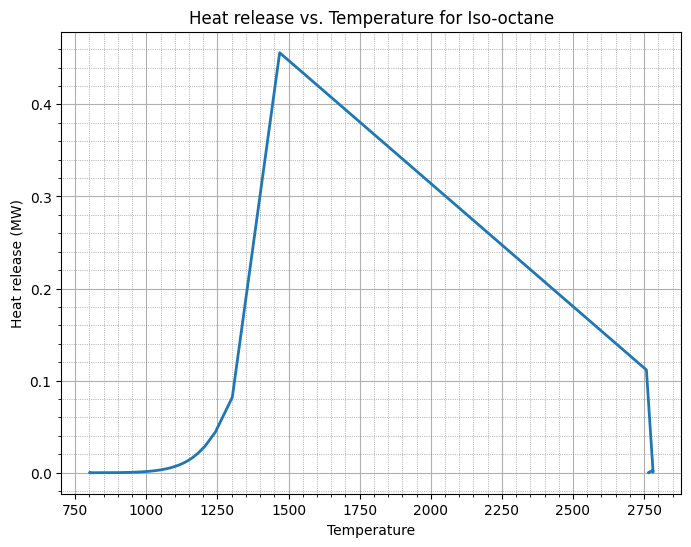

In [88]:
# for Iso-octane
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
gas.TP = Tin, P
# for methane -----------------------------------------------
#gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')
# for iso-octane --------------------------------------------
gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:12.5, N2:47')

# Calculate the volume and surface area of the reactor
volume = (4/3) * np.pi * r**3
surface_area = 4 * np.pi * r**2

# Create an ideal gas reactor
#reactor = ct.IdealGasReactor(gas, volume=volume)
reactor = ct.IdealGasReactor(gas, volume=volume)
#reactor = ct.IdealGasReactor(gas)
simulation=ct.ReactorNet([reactor])


end_time = 5  # End time for simulation in seconds
dt = 1e-4  # Time step for simulation in seconds
no_time_step = end_time/dt
#print(no_time_step)
time = 0.0  # Initial time
time_step_storage = np.arange(dt, end_time, dt)
#heat_release_storage_methane = []
heat_release_storage = []
temperature_history_isoctane = []

# Main calculation 

for n in range(1,int(no_time_step)-1):
    time += dt                
    simulation.advance(time)
    #times2[n] =  time2*1000
    time_step_storage[n] = time
    temperature_history_isoctane.append(gas.T)
    #heat_release = -np.dot(gas.net_rates_of_progress, gas.net_rates_of_progress, gas.delta_enthalpy)
    heat_release = ((gas.heat_release_rate)/1000000)*volume
    #heat_release_storage_isoctane.append(heat_release)
    #heat_release_storage_methane.append(heat_release)
    heat_release_storage.append(np.abs(heat_release))
    #print(f'time step: {time:.2f}, heat release: {heat_release:.2f} KJ')

#print(temperature_history)
#print(size(heat_release_storage))

# Check if ignition occurred
ignition_time = None
temp_difference = None
for i, T in enumerate(temperature_history_isoctane):
    temp_difference = T - Tin
    #print(f'time step: {time_step_storage[i]:.2f} s, temperature difference: {temp_difference:.2f} K')
    
    if temp_difference > 500:
        ignition_time = time_step_storage[i]
        break
    
#print(f'Time to auto-ignite the mixture: {ignition_time:.2f} s')

plt.figure(figsize=(8, 6))
plt.plot( temperature_history_isoctane, heat_release_storage, lw = '2', label = 'iso-octane')
#plt.plot( temperature_history, heat_release_storage_methane, lw = '2', label = 'methane')
plt.xlabel('Temperature')
plt.ylabel('Heat release (MW)')
plt.title('Heat release vs. Temperature for Iso-octane')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

In [76]:
# repeating the steps for Methane

# DEFINING THE CONSTANTS AND VARIAABLES TO STORE -----------------------------------------------------
# Constants
r = 0.037  # Radius in meters
Tin = 800  # Initial temperature in K
P = 101325  # Initial pressure in Pa

phi = 1  # stoichemetric ratio

# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
#gas = ct.Solution('gri30.yaml')
gas.TP = Tin, P
# for methane -----------------------------------------------
gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')
#gas.set_equivalence_ratio(phi, 'H2', 'O2:0.5, N2:1.88')
# for iso-octane --------------------------------------------
#gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:1, N2:3.76')

# Calculate the volume and surface area of the reactor
volume = (4/3) * np.pi * r**3
surface_area = 4 * np.pi * r**2

# Create an ideal gas reactor
#reactor = ct.IdealGasReactor(gas, volume=volume)
reactor = ct.IdealGasReactor(gas, volume=volume)
simulation=ct.ReactorNet([reactor])


time_history = ct.SolutionArray(gas, extra="t")
# CALCULATION OF IGINITION DELAY
import time

def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]
reference_species = "oh"

# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay = 200 # Initial guess for ignition delay in seconds
t = 0

counter = 1
while t < estimated_ignition_delay:
    t = simulation.step()
    if not counter % 10:
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(reactor.thermo.state, t=t)
    counter += 1

# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)

# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")

Computed Ignition Delay: 1.433e+02 seconds. Took 0.57s to compute


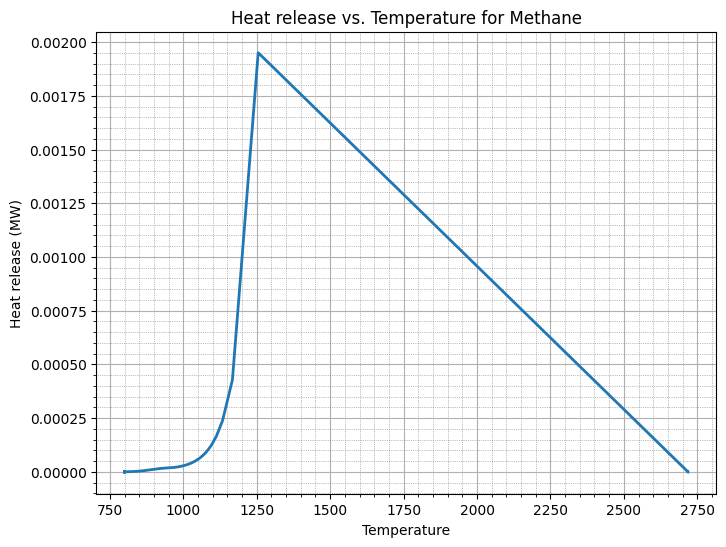

In [77]:
# for Iso-octane
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
gas.TP = Tin, ct.one_atm
# for methane -----------------------------------------------
gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')
# for iso-octane --------------------------------------------
#gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:12.5, N2:47')

# Calculate the volume and surface area of the reactor
volume = (4/3) * np.pi * r**3
surface_area = 4 * np.pi * r**2

# Create an ideal gas reactor
#reactor = ct.IdealGasReactor(gas, volume=volume)
reactor = ct.IdealGasReactor(gas, volume=volume)
#reactor = ct.IdealGasReactor(gas)
simulation=ct.ReactorNet([reactor])


end_time = 200  # End time for simulation in seconds
dt = 1e-2  # Time step for simulation in seconds
no_time_step = end_time/dt
#print(no_time_step)
time = 0.0  # Initial time
time_step_storage = np.arange(dt, end_time, dt)
heat_release_storage_methane = []
#heat_release_storage_isoctane = []
temperature_history = []

# Main calculation 

for n in range(1,int(no_time_step)-1):
    time += dt                
    simulation.advance(time)
    #times2[n] =  time2*1000
    time_step_storage[n] = time
    temperature_history.append(gas.T)
    #heat_release = -np.dot(gas.net_rates_of_progress, gas.net_rates_of_progress, gas.delta_enthalpy)
    heat_release = ((gas.heat_release_rate)/1000000)*volume
    #heat_release_storage_isoctane.append(heat_release)
    heat_release_storage_methane.append(heat_release)
    #heat_release_storage.append(np.abs(heat_release))
    #print(f'time step: {time:.2f}, heat release: {heat_release:.2f} KJ')

#print(temperature_history)
#print(size(heat_release_storage))

# Check if ignition occurred
ignition_time = None
temp_difference = None
for i, T in enumerate(temperature_history):
    temp_difference = T - Tin
    #print(f'time step: {time_step_storage[i]:.2f} s, temperature difference: {temp_difference:.2f} K')
    
    if temp_difference > 500:
        ignition_time = time_step_storage[i]
        break
    
#print(f'Time to auto-ignite the mixture: {ignition_time:.2f} s')

plt.figure(figsize=(8, 6))
#plt.plot( temperature_history, heat_release_storage_isoctane, lw = '2', label = 'iso-octane')
plt.plot( temperature_history, heat_release_storage_methane, lw = '2', label = 'methane')
plt.xlabel('Temperature')
plt.ylabel('Heat release (MW)')
plt.title('Heat release vs. Temperature for Methane')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

[-0.86016807 -0.86016807 -0.86016808 ...  2.52046264  2.52046264
  2.52046264]


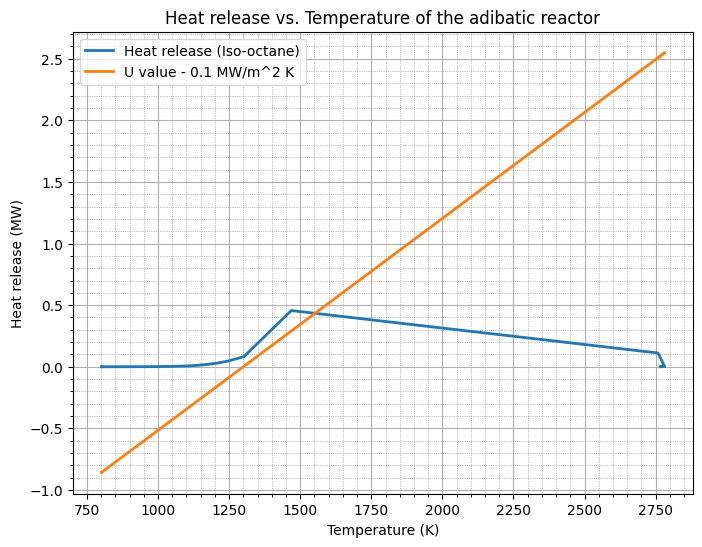

In [34]:
# SEMENOV THEORY - COMPUTATION OF HEAT LOSS BY HAND-------------------------------------
Temp_environment = [1300,1100,1000]  # K
U_values = [0.1, 1.0, 2.0]  # U in MW/m²K
heat_loss_function = np.zeros((len(U_values), len(temperature_history_isoctane)))  # Corrected line

for i in range(len(U_values)):
    for j in range(len(temperature_history_isoctane)):
        #heat_release[j] = heat_release_storage[j]*volume
        heat_loss_function[i][j] = U_values[i]* surface_area * (temperature_history_isoctane[j] - Temp_environment[i])
print(heat_loss_function[0,:])       
plt.figure(figsize=(8, 6))
plt.plot( temperature_history_isoctane,heat_release_storage, lw = '2',label = 'Heat release (Iso-octane)')
plt.plot( temperature_history_isoctane,heat_loss_function[0,:], lw = '2',label = 'U value - 0.1 MW/m^2 K')
#plt.plot( temperature_history_isoctane,heat_loss_function[1,:], lw = '2',label = 'U value - 1.0 MW/m^2 K')
#plt.plot( temperature_history_isoctane,heat_loss_function[2,:],lw = '2',label = 'U value - 2.0 MW/m^2 K')
plt.ylabel('Heat release (MW)')
plt.xlabel('Temperature (K)')
plt.title('Heat release vs. Temperature of the adibatic reactor')
plt.legend()
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()


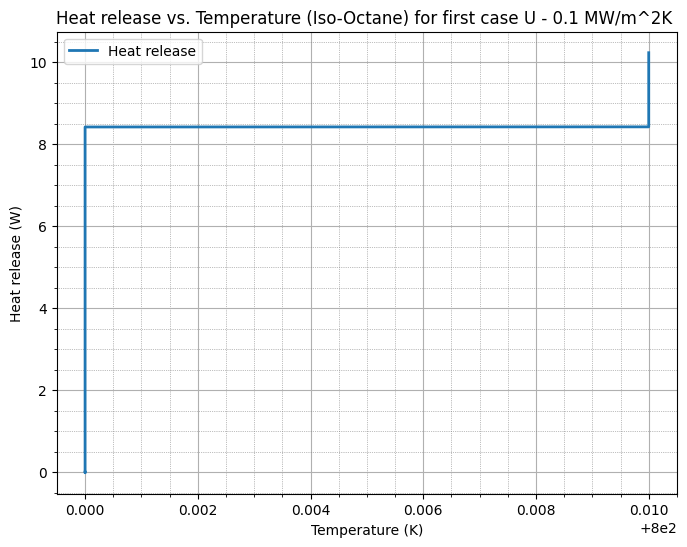

In [45]:
# Part 3 - Q9 & Q 10


# Constants
r = 0.037  # Radius in meters
Tin = 800  # Initial temperature in K
P = 101325  # Initial pressure in Pa

phi = 1  # stoichemetric ratio

# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
gas.TP = Tin, P
# for methane -----------------------------------------------
#gas.set_equivalence_ratio(phi, 'CH4', 'O2:12.5, N2:47')
# for iso-octane --------------------------------------------
gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:12.5, N2:47')

# Calculate the volume and surface area of the reactor
volume = (4/3) * np.pi * r**3
surface_area = 4 * np.pi * r**2

# Create an ideal gas reactor
#reactor = ct.IdealGasReactor(gas, volume=volume)
reactor = ct.IdealGasReactor(gas, volume=volume)

# create a reservoir for the environment, and fill it with air.
#environment = ct.Reservoir(ct.Solution('air.yaml'))
gas2 = ct.Solution('air.yaml') 
gas2.TP = 1300, ct.one_atm
environment = ct.IdealGasReactor(gas)


wall = ct.Wall(reactor, environment, name=None, A= surface_area, K=None, U=100000, Q=None, velocity=None)

simulation=ct.ReactorNet([reactor])

end_time = 5  # End time for simulation in seconds
dt = 1e-4  # Time step for simulation in seconds
no_time_step = end_time/dt
#print(no_time_step)
time = 0.0  # Initial time
time_step_storage = np.arange(dt, end_time, dt)
heat_release_storage = []
temperature_history = []

# Main calculation 

for n in range(1,int(no_time_step)-1):
    time += dt                
    simulation.advance(time)
    #times2[n] =  time2*1000
    time_step_storage[n] = time
    temperature_history.append(round(gas.T,2))
    #heat_release = -np.dot(gas.net_rates_of_progress, gas.net_rates_of_progress, gas.delta_enthalpy)
    heat_release = (gas.heat_release_rate)*volume
    heat_release_storage.append(heat_release)
    #print(f'time step: {time:.2f}, heat release: {heat_release:.2f} W/m^3')

ignition_time = None
temp_difference = None
for i, T in enumerate(temperature_history):
    temp_difference = T - Tin 
    #print(f'time step: {time_step_storage[i]:.2f} s, temperature difference: {temp_difference:.2f} K')
    
    if temp_difference >  500:
        ignition_time = time_step_storage[i]
        break
#print(temperature_history)
# Plotting the heat release
plt.figure(figsize=(8, 6))
plt.plot( temperature_history,heat_release_storage, lw = '2',label = 'Heat release')
#plt.plot( temperature_history,heat_loss_function[0,:], lw = '2',label = 'U value - 0.1')
#plt.plot( temperature_history,heat_loss_function[1,:], lw = '2',label = 'U value - 1.0')
#plt.plot( temperature_history,heat_loss_function[2,:],lw = '2',label = 'U value - 2.0')
plt.ylabel('Heat release (W)')
plt.xlabel('Temperature (K)')
plt.title('Heat release vs. Temperature (Iso-Octane) for first case U - 0.1 MW/m^2K ')
plt.legend()
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

In [42]:
# Create an empty list to store ignition temperatures
ignition_temperatures = []
pressure_storage = []
# Pressure range from 1/1000 atm to 10,000 atm in steps of 10^n
pressure_range = np.logspace(-3, 4, num=16)

found_ignition = False  # Initialize a flag variable
ignition_temperatures = []
gas = ct.Solution('gri30.yaml')
for pressure in pressure_range:
    #ignition_temperature = []
    for initial_temperature in range(300, 951, 10):
        if found_ignition:  # Check if ignition has already been found
            found_ignition = False
            
            break  # Skip the current iteration of the inner loop if ignition has been found
        
        gas.TP = initial_temperature, pressure
        gas.set_equivalence_ratio(phi, 'H2', 'O2:0.5, N2:1.88')
        
        # Create an IdealGasReactor
        reactor = ct.IdealGasReactor(gas, volume=volume)

        # Create a reactor network
        simulation = ct.ReactorNet([reactor])
        
        # Time variables
        end_time = 10.5  # End time for simulation in seconds
        dt = 1e-4  # Time step for simulation in seconds
        no_time_step = end_time / dt
        time = 0.0  # Initial time
        
        for n in range(1, int(no_time_step) - 1):
            if found_ignition:  # Check if ignition has already been found
                break  # Exit the inner loop if ignition has been found
            time += dt                
            simulation.advance(time)
            if gas.T - initial_temperature > 500:
                print(f'At Pressure: {pressure:.2f} s, Minimum Ignition Temperature: {initial_temperature:.2f} K')
                ignition_temperatures.append(initial_temperature)
                pressure_storage.append(pressure)
                found_ignition = True  # Set the flag to True
                break
    #ignition_temperatures.append(initial_temperature)

# If ignition has been found, this message will be printed
if found_ignition:
    print("Ignition started, continuing pressure loop")


At Pressure: 46.42 s, Minimum Ignition Temperature: 720.00 K
At Pressure: 135.94 s, Minimum Ignition Temperature: 640.00 K
At Pressure: 398.11 s, Minimum Ignition Temperature: 640.00 K
At Pressure: 1165.91 s, Minimum Ignition Temperature: 670.00 K
At Pressure: 3414.55 s, Minimum Ignition Temperature: 720.00 K
At Pressure: 10000.00 s, Minimum Ignition Temperature: 780.00 K


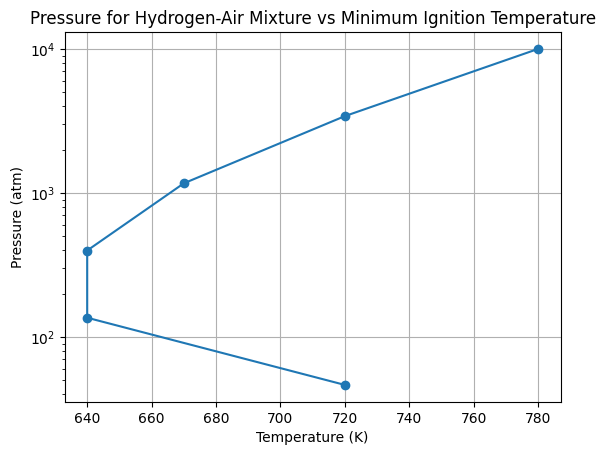

In [29]:
#new_pressure_range = [100, 1000, 10000]
# Plot the results on a semi-log graph
plt.semilogy(ignition_temperatures, pressure_storage,  marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (atm)')
plt.title('Pressure for Hydrogen-Air Mixture vs Minimum Ignition Temperature')
plt.grid(True)
plt.show()


**Part IV - Constant Pressure Iginition**

In [78]:
# CALCULATION OF IGINITION DELAY
import time

def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]
reference_species = "oh"


Computed Ignition Delay: 1.368e+01 seconds. At Temperature 500.00 K
Computed Ignition Delay: 1.415e+01 seconds. At Temperature 550.00 K
Computed Ignition Delay: 1.982e+01 seconds. At Temperature 600.00 K
Computed Ignition Delay: 1.952e+01 seconds. At Temperature 650.00 K
Computed Ignition Delay: 1.392e+01 seconds. At Temperature 700.00 K
Computed Ignition Delay: 1.836e+00 seconds. At Temperature 750.00 K
Computed Ignition Delay: 3.186e-01 seconds. At Temperature 800.00 K
Computed Ignition Delay: 7.157e-02 seconds. At Temperature 850.00 K
Computed Ignition Delay: 2.069e-02 seconds. At Temperature 900.00 K
Computed Ignition Delay: 7.528e-03 seconds. At Temperature 950.00 K
Computed Ignition Delay: 3.341e-03 seconds. At Temperature 1000.00 K
Computed Ignition Delay: 1.681e-03 seconds. At Temperature 1050.00 K
Computed Ignition Delay: 8.737e-04 seconds. At Temperature 1100.00 K
Computed Ignition Delay: 4.572e-04 seconds. At Temperature 1150.00 K
Computed Ignition Delay: 2.484e-04 seconds. 

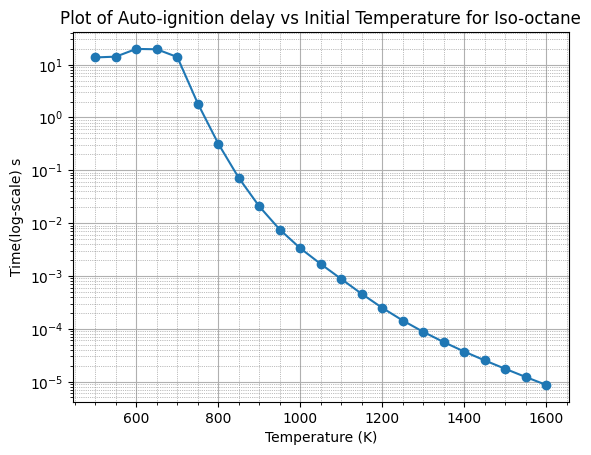

In [81]:
# CONSTANTS-----------------------------------------------
#Tin = 800  # Initial temperature in K
P = 101325  # Initial pressure in Pa
temperature_range = np.arange(500, 1610, 50)    # 766 K for the methane combustion
#temperature_range = np.hstack((np.arange(500, 800, 25), np.arange(800, 1610, 100)))
phi = 1  # stoichemetric ratio
time_storage_p1 = [] # at pressure one_atm
#time_storage_p5 = [] # at pressure one_atm
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
time_history = ct.SolutionArray(gas, extra="t")
for i, temp in enumerate(temperature_range):
    tau = None
    gas.TP = temp, 15*ct.one_atm
    # for methane -----------------------------------------------
    #gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')

    # for iso-octane --------------------------------------------
    gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:12.5, N2:47')

    # Create an ideal gas reactor
    #reactor = ct.IdealGasReactor(gas, volume=volume)
    reactor = ct.IdealGasConstPressureReactor(gas)
    simulation=ct.ReactorNet([reactor])

    # Tic
    t0 = time.time()

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimated_ignition_delay = 20  # Initial guess for ignition delay in seconds
    t = 0

    counter = 1
    while t < estimated_ignition_delay:
        t = simulation.step()
        if not counter % 10:
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            time_history.append(reactor.thermo.state, t=t)
        counter += 1
    if len(time_history) == 0:
        print(f"No ignition event at Temperature {temp:3.2f} K")
    else:
        tau = ignition_delay(time_history, reference_species)
        time_storage_p1.append(tau)
        #time_storage_p5.append(tau)
        #print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")
    '''
    # We will use the 'oh' species to compute the ignition delay
    tau = ignition_delay(time_history, reference_species)
    time_storage.append(tau)
    '''
    # Toc
    t1 = time.time()
    
    print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")
# Plot the results on a semi-log graph
plt.semilogy(temperature_range, time_storage_p1,  marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Time(log-scale) s')
plt.title('Plot of Auto-ignition delay vs Initial Temperature for Iso-octane')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

In [197]:
# for pressure variation in case of iso-octane ----------------


# CONSTANTS-----------------------------------------------
#Tin = 800  # Initial temperature in K
P = 101325  # Initial pressure in Pa
temperature_range = np.arange(500, 1610, 50)    # 766 K for the methane combustion
pressure_range = np.arange(1, 21, 5)    # 766 K for the methane combustion
#print(len(temperature_range))
#temperature_range = np.hstack((np.arange(500, 800, 25), np.arange(800, 1610, 100)))
phi = 1  # stoichemetric ratio
time_storage = np.zeros((len(pressure_range), len(temperature_range)))
#time_storage_p5 = [] # at pressure one_atm
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
time_history = ct.SolutionArray(gas, extra="t")
for j in range(len(pressure_range)):
    tau = None
    for i, temp in enumerate(temperature_range):
        tau = None
        gas.TP = temp, ct.one_atm
        # for methane -----------------------------------------------
        #gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')

        # for iso-octane --------------------------------------------
        gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:12.5, N2:47')

        # Create an ideal gas reactor
        #reactor = ct.IdealGasReactor(gas, volume=volume)
        reactor = ct.IdealGasConstPressureReactor(gas)
        simulation=ct.ReactorNet([reactor])

        # Tic
        t0 = time.time()
    
        # This is a starting estimate. If you do not get an ignition within this time, increase it
        estimated_ignition_delay = 25  # Initial guess for ignition delay in seconds
        t = 0

        counter = 1
        while t < estimated_ignition_delay:
            t = simulation.step()
            if not counter % 10:
                # We will save only every 10th value. Otherwise, this takes too long
                # Note that the species concentrations are mass fractions
                time_history.append(reactor.thermo.state, t=t)
            counter += 1
        if len(time_history) == 0:
            print(f"No ignition event at Temperature {temp:3.2f} K")
        else:
            tau = ignition_delay(time_history, reference_species)
            time_storage[j,i] = tau
            #time_storage_p5.append(tau)
            #print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")
        '''
        # We will use the 'oh' species to compute the ignition delay
        tau = ignition_delay(time_history, reference_species)
        time_storage.append(tau)
        '''
        # Toc
        t1 = time.time()
    
    print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")


Computed Ignition Delay: 9.579e-05 seconds. At Temperature 1600.00 K
Computed Ignition Delay: 9.579e-05 seconds. At Temperature 1600.00 K
Computed Ignition Delay: 9.579e-05 seconds. At Temperature 1600.00 K
Computed Ignition Delay: 9.579e-05 seconds. At Temperature 1600.00 K


[9.57879333e-05 9.57879333e-05 9.57879333e-05 9.57879333e-05
 9.57879333e-05 9.57879333e-05 9.57879333e-05 9.57879333e-05
 9.57879333e-05 9.57879333e-05 9.57879333e-05 9.57879333e-05
 9.57879333e-05 9.57879333e-05 9.57879333e-05 9.57879333e-05
 9.57879333e-05 9.57879333e-05 9.57879333e-05 9.57879333e-05
 9.57879333e-05 9.57879333e-05 9.57879333e-05]


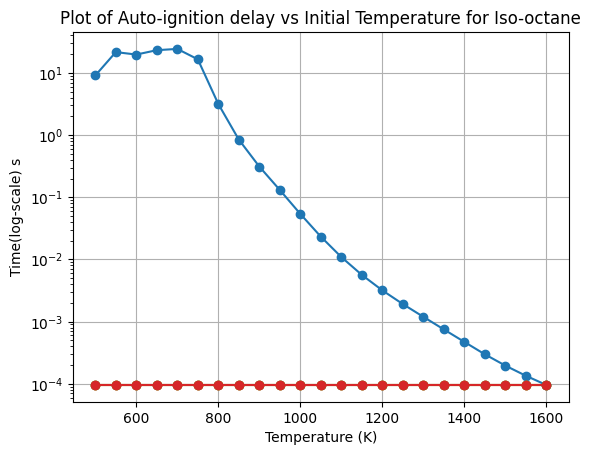

In [199]:
# Plot the results on a semi-log graph
print(time_storage[1,:])
plt.semilogy(temperature_range, time_storage[0,:],  marker='o')
plt.semilogy(temperature_range, time_storage[1,:],  marker='o')
plt.semilogy(temperature_range, time_storage[2,:],  marker='o')
plt.semilogy(temperature_range, time_storage[3,:],  marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Time(log-scale) s')
plt.title('Plot of Auto-ignition delay vs Initial Temperature for Iso-octane')
plt.grid(True)
plt.show()

In [52]:
# METHANE - AUTO IGNITION DELAY CALCULTAION

# CONSTANTS-----------------------------------------------
#Tin = 800  # Initial temperature in K
P = 101325  # Initial pressure in Pa
temperature_range = np.arange(500, 1610, 50)    # 766 K for the methane combustion
#temperature_range = np.hstack((np.arange(500, 800, 25), np.arange(800, 1610, 100)))
phi = 1  # stoichemetric ratio
time_storage_p1_methane = [] # at pressure one_atm
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Jerzembeck.yaml')
time_history = ct.SolutionArray(gas, extra="t")
for i, temp in enumerate(temperature_range):
    tau = None
    gas.TP = temp, ct.one_atm
    # for methane -----------------------------------------------
    gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')

    # for iso-octane --------------------------------------------
    #gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:12.5, N2:47')

    # Create an ideal gas reactor
    #reactor = ct.IdealGasReactor(gas, volume=volume)
    reactor = ct.IdealGasConstPressureReactor(gas)
    simulation=ct.ReactorNet([reactor])

    # Tic
    t0 = time.time()

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimated_ignition_delay = 1000  # Initial guess for ignition delay in seconds
    t = 0

    counter = 1
    while t < estimated_ignition_delay:
        t = simulation.step()
        if not counter % 10:
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            time_history.append(reactor.thermo.state, t=t)
        counter += 1
    if len(time_history) == 0:
        print(f"No ignition event at Temperature {temp:3.2f} K")
        tau = estimated_ignition_delay
        time_storage_p1_methane.append(tau)
        continue
    else:
        tau = ignition_delay(time_history, reference_species)
        time_storage_p1_methane.append(tau)
        #print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")
    '''
    # We will use the 'oh' species to compute the ignition delay
    tau = ignition_delay(time_history, reference_species)
    time_storage.append(tau)
    '''
    # Toc
    t1 = time.time()
    
    print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")



No ignition event at Temperature 500.00 K
No ignition event at Temperature 550.00 K
No ignition event at Temperature 600.00 K
No ignition event at Temperature 650.00 K
No ignition event at Temperature 700.00 K
Computed Ignition Delay: 9.980e+02 seconds. At Temperature 750.00 K
Computed Ignition Delay: 1.455e+02 seconds. At Temperature 800.00 K
Computed Ignition Delay: 2.598e+01 seconds. At Temperature 850.00 K
Computed Ignition Delay: 7.603e+00 seconds. At Temperature 900.00 K
Computed Ignition Delay: 3.180e+00 seconds. At Temperature 950.00 K
Computed Ignition Delay: 1.450e+00 seconds. At Temperature 1000.00 K
Computed Ignition Delay: 6.808e-01 seconds. At Temperature 1050.00 K
Computed Ignition Delay: 3.302e-01 seconds. At Temperature 1100.00 K
Computed Ignition Delay: 1.655e-01 seconds. At Temperature 1150.00 K
Computed Ignition Delay: 8.561e-02 seconds. At Temperature 1200.00 K
Computed Ignition Delay: 4.546e-02 seconds. At Temperature 1250.00 K
Computed Ignition Delay: 2.470e-02 s

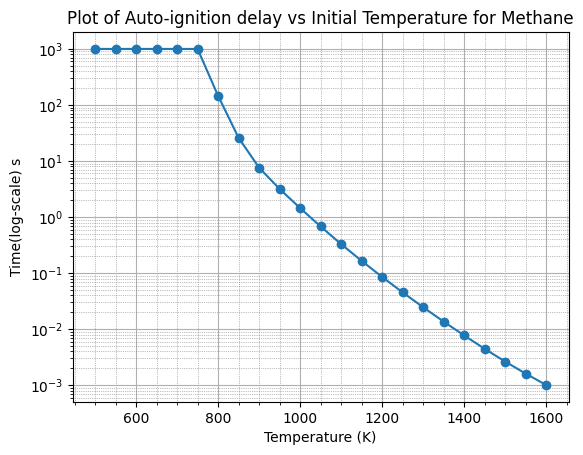

In [53]:
# Plot the results on a semi-log graph
plt.semilogy(temperature_range, time_storage_p1_methane,  marker='o')
plt.xlabel('Temperature (K)')
plt.ylabel('Time(log-scale) s')
plt.title('Plot of Auto-ignition delay vs Initial Temperature for Methane')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

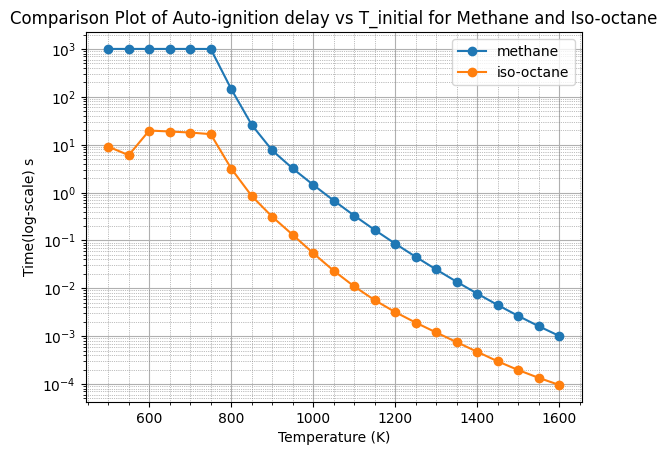

In [54]:
# Plot the results on a semi-log graph
plt.semilogy(temperature_range, time_storage_p1_methane,  marker='o', label = 'methane')
plt.semilogy(temperature_range, time_storage_p1,  marker='o', label = 'iso-octane')
plt.xlabel('Temperature (K)')
plt.ylabel('Time(log-scale) s')
plt.title('Comparison Plot of Auto-ignition delay vs T_initial for Methane and Iso-octane')
plt.legend()
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

In [67]:
# for HEPTANE----------------------------------

# CALCULATION OF IGINITION DELAY
import time

def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]
reference_species = "oh"

In [68]:
# CONSTANTS-----------------------------------------------
#Tin = 800  # Initial temperature in K
P = 101325  # Initial pressure in Pa
#temperature_range = np.arange(500, 1610, 50)    # 766 K for the methane combustion
#temperature_range = np.hstack((np.arange(1800, 900, -50), np.arange(925, 475, -25)))
temperature_range = np.hstack((np.arange(500, 800, 10), np.arange(800, 1610, 50)))
#temperature_range = np.hstack((np.arange(500, 800, 25), np.arange(800, 1610, 100)))
phi = 1  # stoichemetric ratio
time_storage_p1 = [] # at pressure one_atm
#time_storage_p5 = [] # at pressure one_atm
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Seiser.yaml')
time_history = ct.SolutionArray(gas, extra="t")
for i, temp in enumerate(temperature_range):
    tau = None
    gas.TP = temp, ct.one_atm
    # for methane -----------------------------------------------
    #gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')

    # for iso-octane --------------------------------------------
    gas.set_equivalence_ratio(phi, 'nc7h16', 'O2:11, N2:41.36')

    # Create an ideal gas reactor
    #reactor = ct.IdealGasReactor(gas, volume=volume)
    reactor = ct.IdealGasConstPressureReactor(gas)
    simulation=ct.ReactorNet([reactor])

    # Tic
    t0 = time.time()

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimated_ignition_delay = 100  # Initial guess for ignition delay in seconds
    t = 0

    counter = 1
    while t < estimated_ignition_delay:
        t = simulation.step()
        if not counter % 10:
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            time_history.append(reactor.thermo.state, t=t)
        counter += 1
    if len(time_history) == 0:
        print(f"No ignition event at Temperature {temp:3.2f} K")
    else:
        tau = ignition_delay(time_history, reference_species)
        time_storage_p1.append(tau)
        #time_storage_p5.append(tau)
        #print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")
    '''
    # We will use the 'oh' species to compute the ignition delay
    tau = ignition_delay(time_history, reference_species)
    time_storage.append(tau)
    '''
    # Toc
    t1 = time.time()
    
    print(f"Computed Ignition Delay: {tau:.3e} seconds. At Temperature {temp:3.2f} K")

C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_19076\3597002012.py:12: UserWarning: NasaPoly2::validate: 
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.83428060093267
	Value computed using high-temperature polynomial: 21.76699500201913

  gas = ct.Solution('Seiser.yaml')


Computed Ignition Delay: 7.316e+01 seconds. At Temperature 500.00 K
Computed Ignition Delay: 3.816e+01 seconds. At Temperature 510.00 K
Computed Ignition Delay: 2.059e+01 seconds. At Temperature 520.00 K
Computed Ignition Delay: 1.146e+01 seconds. At Temperature 530.00 K
Computed Ignition Delay: 6.572e+00 seconds. At Temperature 540.00 K
Computed Ignition Delay: 3.876e+00 seconds. At Temperature 550.00 K
Computed Ignition Delay: 2.346e+00 seconds. At Temperature 560.00 K
Computed Ignition Delay: 1.456e+00 seconds. At Temperature 570.00 K
Computed Ignition Delay: 9.286e-01 seconds. At Temperature 580.00 K
Computed Ignition Delay: 6.097e-01 seconds. At Temperature 590.00 K
Computed Ignition Delay: 4.136e-01 seconds. At Temperature 600.00 K
Computed Ignition Delay: 2.916e-01 seconds. At Temperature 610.00 K
Computed Ignition Delay: 2.147e-01 seconds. At Temperature 620.00 K
Computed Ignition Delay: 1.663e-01 seconds. At Temperature 630.00 K
Computed Ignition Delay: 1.364e-01 seconds. At T

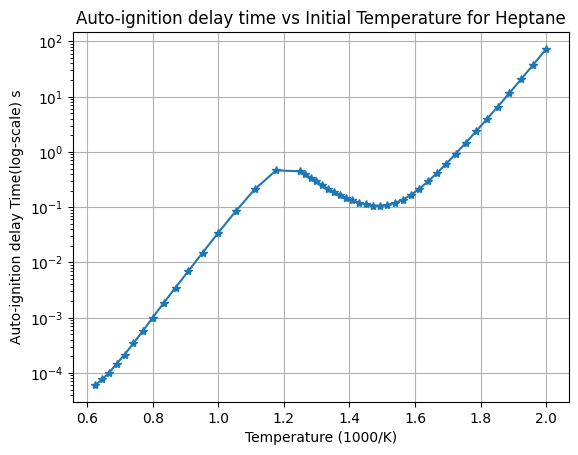

In [69]:
temperature_range_inv = []
for i in range(len(temperature_range)):
    temperature_range_inv.append(1000 / temperature_range[i])

# Plot the results on a semi-log graph
plt.semilogy(temperature_range_inv, time_storage_p1,  marker = '*')
plt.xlabel('Temperature (1000/K)')
plt.ylabel('Auto-ignition delay Time(log-scale) s')
plt.title('Auto-ignition delay time vs Initial Temperature for Heptane')
plt.grid(True)
plt.show()

C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_19076\2751249085.py:10: UserWarning: NasaPoly2::validate: 
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.83428060093267
	Value computed using high-temperature polynomial: 21.76699500201913

  gas = ct.Solution('Seiser.yaml')


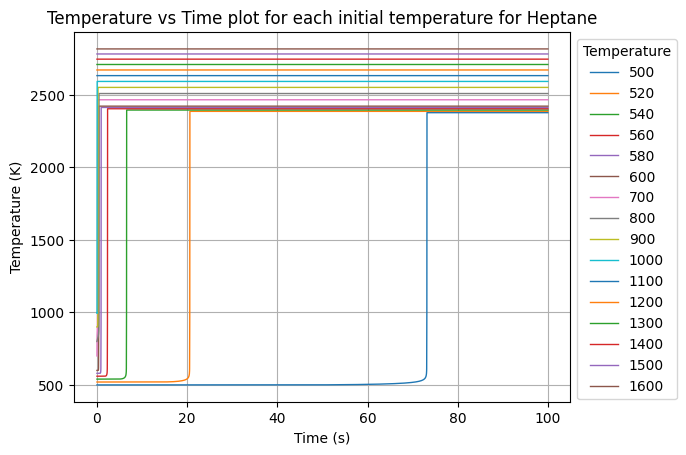

In [3]:
# calculation of temp vs time for each initial temp HEPTANE

# for Iso-octane
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
temperature_range = np.hstack((np.arange(500, 600, 20), np.arange(600, 1610, 100)))
phi = 1  # stoichemetric ratio
time_storage_p1 = [] # at pressure one_atm
#time_storage_p5 = [] # at pressure one_atm
# Define the mixture for iso-octane (based on Jerzembeck mechanism)
gas = ct.Solution('Seiser.yaml')

for i, temp in enumerate(temperature_range):
    tau = None
    gas.TP = temp, ct.one_atm
    # for methane -----------------------------------------------
    #gas.set_equivalence_ratio(phi, 'CH4', 'O2:2, N2:7.52')

    # for iso-octane --------------------------------------------
    gas.set_equivalence_ratio(phi, 'nc7h16', 'O2:11, N2:41.36')

    # Create an ideal gas reactor
    #reactor = ct.IdealGasReactor(gas, volume=volume)
    reactor = ct.IdealGasConstPressureReactor(gas)
    simulation=ct.ReactorNet([reactor])

    end_time = 100  # End time for simulation in seconds
    dt = 1e-2  # Time step for simulation in seconds
    no_time_step = end_time/dt
    #print(no_time_step)
    time = 0.0  # Initial time
    time_step_storage = np.arange(dt, end_time, dt)
    temperature_history = []

# Main calculation 

    for n in range(int(no_time_step)-1):
        time += dt                
        simulation.advance(time)
        time_step_storage[n] = time
        temperature_history.append(gas.T)
    
    plt.plot(time_step_storage,temperature_history, lw = 1, label = str(temp))
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title('Temperature vs Time plot for each initial temperature for Heptane')
    plt.legend(loc='upper left', title='Temperature', bbox_to_anchor=(1, 1))
    plt.grid(True)
    #plt.show()

**Part IV - Perfectly stirred reactor**

In [139]:
T_initial = 800    # K
P_initial = 30    # atm
Heating_value = 45    #MJ/Kg
efficiency = 0.42     # 42% efficiency of gas turbine
Power_output = 120    # MJ/s
Combustor_volume = 0.4    #m^3
Air_flow_rate = 240   #Kg/s
Air_Mol_wt = 28.96    # Kg/Kmol
Iso_octane_Mol_wt = 114.23  #Kg/Kmol
Air_fuel_ratioStoic = 15.02   # 1 Kmol of Iso-octane requires 12.5 Kmol of Air, by mass = 15.022

# total power required from combustion for the power output of 120 MJ/s
power_combustion = Power_output/efficiency
print(f"Energy required from combustion: {power_combustion:.3f} MW for the power output of {Power_output:3.2f} MW")
#print(power_combustion)

# total mass of iso-octane required to fullfill this need
total_mass_iso_octane = power_combustion/Heating_value
#print(total_mass_iso_octane)
print(f"Mass flow rate of Iso-Octane required: {total_mass_iso_octane:.3f} Kg/s")

# for the iso-octane amount, the amount of air required - 
total_mass_air = total_mass_iso_octane*Air_fuel_ratioStoic
print(f"Based on the stoichiometric ratio, mass flow rate of air required: {total_mass_air:.3f} Kg/s")

Air_fuel_ratioActual = (Air_flow_rate/total_mass_iso_octane) 
phi_overall = Air_fuel_ratioStoic/Air_fuel_ratioActual
print(f"Overall Equivalence ratio: {phi_overall:.3f}")

Energy required from combustion: 285.714 MW for the power output of 120.00 MW
Mass flow rate of Iso-Octane required: 6.349 Kg/s
Based on the stoichiometric ratio, mass flow rate of air required: 95.365 Kg/s
Overall Equivalence ratio: 0.397


In [140]:
# ADIBATIC FLAME TEMPERATURES AND MOLE FRACTIONS CO & NO

# species list to find composition at quilibrium
species_list = ["CO","NO","CO2"]

#adiabatic_flame_temperature = None
# species list to find composition at quilibrium, const P initial(Pin), and T initial(Tin)
species_list_const_Pin_Tin = np.zeros(len(species_list))

#Create a gas object using the Jerzembeck mechanism
gas = ct.Solution('Jerzembeck.yaml')

gas.TP = T_initial, P_initial*101325
gas.set_equivalence_ratio(phi_overall, 'IXC8H18', 'O2:12.5, N2:47')
gas.equilibrate('HP')
adiabatic_flame_temperature = round(gas.T,2)
print(adiabatic_flame_temperature)

for sp in species_list:
    #mole_fractions = combustor.thermo[sp].X
    mole_fractions = gas[sp].X
    if sp == "CO":
        species_list_const_Pin_Tin[0] = mole_fractions[0]
    elif sp == "NO" :
        species_list_const_Pin_Tin[1] = mole_fractions[0]
    else:
        species_list_const_Pin_Tin[2] = mole_fractions[0]

print(species_list_const_Pin_Tin)

1718.4
[2.27015597e-06 2.35587490e-03 5.18640290e-02]


In [141]:
T_initial = 800    # K
P_initial = 30    # atm
species_list_const_Pin_Tin_PSR = np.zeros(len(species_list))

#Create a gas object using the Jerzembeck mechanism
gas = ct.Solution('Jerzembeck.yaml')

gas.TP = T_initial, P_initial*ct.one_atm
gas.set_equivalence_ratio(phi_overall, 'IXC8H18', 'O2:12.5, N2:47')

# Create a reservoir for the inlet
inlet = ct.Reservoir(gas)
gas.equilibrate('HP')

combustor = ct.IdealGasReactor(gas)
combustor.volume = Combustor_volume

# Create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

# Use a variable mass flow rate to keep the residence time in the reactor
# constant (residence_time = mass / mass_flow_rate). The mass flow rate function
# can access variables defined in the calling scope, including state variables
# of the Reactor object (combustor) itself.


def mdot(t):
    return combustor.mass / residence_time


inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

# A PressureController has a baseline mass flow rate matching the 'primary'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(combustor, exhaust, primary=inlet_mfc, K=0.01)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

T_difference = 100
residence_time = 0.01
T_initial_combustor = 800
# Run a loop over decreasing residence times, until the reactor is extinguished,
# saving the state after each iteration.
states = ct.SolutionArray(gas, extra=['tres'])

while T_difference > 1e-4:
    
    sim.initial_time = 0.0  # reset the integrator
    sim.advance_to_steady_state()
    
    print('tres = {:.2e}; T = {:.1f}'.format(residence_time, combustor.T))
    states.append(combustor.thermo.state, tres=residence_time)
    T_difference = combustor.T - T_initial_combustor
    print(T_difference)
    T_initial_combustor = combustor.T
    residence_time *= 1.1  # decrease the residence time for the next iteration
    
for sp in species_list:
    mole_fractions = combustor.thermo[sp].X
    if sp == "CO":
        species_list_const_Pin_Tin_PSR[0] = mole_fractions[0]
    elif sp == "NO" :
        species_list_const_Pin_Tin_PSR[1] = mole_fractions[0]
    else:
        species_list_const_Pin_Tin_PSR[2] = mole_fractions[0]

final_residence_time = residence_time
print(final_residence_time)
print(species_list_const_Pin_Tin_PSR)
'''
# Plot results
f, ax1 = plt.subplots(1, 1)
ax1.plot(states.tres, states.heat_release_rate, '.-', color='C0')
ax2 = ax1.twinx()
ax2.plot(states.tres[:-1], states.T[:-1], '.-', color='C1')
ax1.set_xlabel('residence time [s]')
ax1.set_ylabel('heat release rate [W/m$^3$]', color='C0')
ax2.set_ylabel('temperature [K]', color='C1')
f.tight_layout()
plt.show()
'''

tres = 1.00e-02; T = 1721.3
921.2604499282215
tres = 1.10e-02; T = 1721.5
0.19604910428211042
tres = 1.21e-02; T = 1721.6
0.18274407626131506
tres = 1.33e-02; T = 1721.8
0.17036489531187726
tres = 1.46e-02; T = 1722.0
0.15884154062496236
tres = 1.61e-02; T = 1722.1
0.14810937706556615
tres = 1.77e-02; T = 1722.3
0.1381087340062095
tres = 1.95e-02; T = 1722.4
0.12878452113227468
tres = 2.14e-02; T = 1722.5
0.12008588052208324
tres = 2.36e-02; T = 1722.6
0.11196587002405067
tres = 2.59e-02; T = 1722.7
0.10438117600347141
tres = 2.85e-02; T = 1722.8
0.09729184758271003
tres = 3.14e-02; T = 1722.9
0.09066105723513829
tres = 3.45e-02; T = 1723.0
0.08445487719882294
tres = 3.80e-02; T = 1723.1
0.07864207415741475
tres = 4.18e-02; T = 1723.1
0.07319392205135955
tres = 4.59e-02; T = 1723.2
0.06808401252828844
tres = 5.05e-02; T = 1723.3
0.06328810233480908
tres = 5.56e-02; T = 1723.3
0.05878393852935915
tres = 6.12e-02; T = 1723.4
0.054551111769569616
tres = 6.73e-02; T = 1723.4
0.050570905651

"\n# Plot results\nf, ax1 = plt.subplots(1, 1)\nax1.plot(states.tres, states.heat_release_rate, '.-', color='C0')\nax2 = ax1.twinx()\nax2.plot(states.tres[:-1], states.T[:-1], '.-', color='C1')\nax1.set_xlabel('residence time [s]')\nax1.set_ylabel('heat release rate [W/m$^3$]', color='C0')\nax2.set_ylabel('temperature [K]', color='C1')\nf.tight_layout()\nplt.show()\n"

**Extra for part IV from example given**

tres = 3.00e-01; T = 1723.9
tres = 2.70e-01; T = 1723.8
tres = 2.43e-01; T = 1723.8
tres = 2.19e-01; T = 1723.8
tres = 1.97e-01; T = 1723.8
tres = 1.77e-01; T = 1723.8
tres = 1.59e-01; T = 1723.8
tres = 1.43e-01; T = 1723.7
tres = 1.29e-01; T = 1723.7
tres = 1.16e-01; T = 1723.7
tres = 1.05e-01; T = 1723.6
tres = 9.41e-02; T = 1723.6
tres = 8.47e-02; T = 1723.5
tres = 7.63e-02; T = 1723.5
tres = 6.86e-02; T = 1723.4
tres = 6.18e-02; T = 1723.4
tres = 5.56e-02; T = 1723.3
tres = 5.00e-02; T = 1723.3
tres = 4.50e-02; T = 1723.2
tres = 4.05e-02; T = 1723.1
tres = 3.65e-02; T = 1723.0
tres = 3.28e-02; T = 1722.9
tres = 2.95e-02; T = 1722.9
tres = 2.66e-02; T = 1722.7
tres = 2.39e-02; T = 1722.6
tres = 2.15e-02; T = 1722.5
tres = 1.94e-02; T = 1722.4
tres = 1.74e-02; T = 1722.2
tres = 1.57e-02; T = 1722.1
tres = 1.41e-02; T = 1721.9
tres = 1.27e-02; T = 1721.7
tres = 1.14e-02; T = 1721.5
tres = 1.03e-02; T = 1721.3
tres = 9.27e-03; T = 1721.1
tres = 8.34e-03; T = 1720.8
tres = 7.51e-03; T =

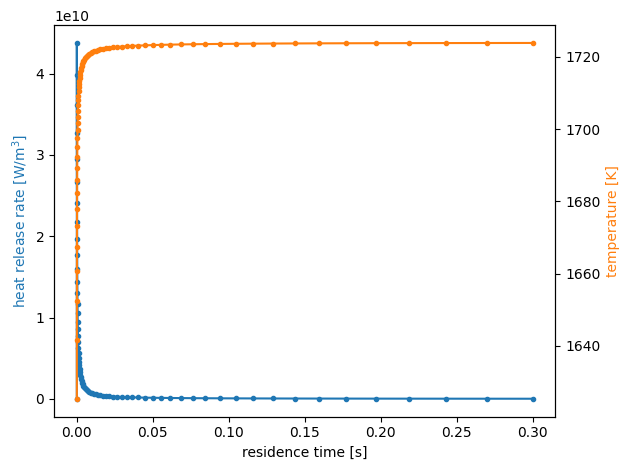

In [142]:
T_initial = 800    # K
P_initial = 30    # atm
adiabatic_flame_temperature_PSR = None
species_list_const_Pin_Tin_PSR = np.zeros(len(species_list))

#Create a gas object using the Jerzembeck mechanism
gas = ct.Solution('Jerzembeck.yaml')

gas.TP = T_initial, P_initial*ct.one_atm
gas.set_equivalence_ratio(phi_overall, 'IXC8H18', 'O2:12.5, N2:47')

# Create a reservoir for the inlet
inlet = ct.Reservoir(gas)
gas.equilibrate('HP')

combustor = ct.IdealGasReactor(gas)
combustor.volume = Combustor_volume

# Create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

# Use a variable mass flow rate to keep the residence time in the reactor
# constant (residence_time = mass / mass_flow_rate). The mass flow rate function
# can access variables defined in the calling scope, including state variables
# of the Reactor object (combustor) itself.


def mdot(t):
    return combustor.mass / residence_time


inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

# A PressureController has a baseline mass flow rate matching the 'primary'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(combustor, exhaust, primary=inlet_mfc, K=0.01)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

# Run a loop over decreasing residence times, until the reactor is extinguished,
# saving the state after each iteration.
states = ct.SolutionArray(gas, extra=['tres'])

residence_time = 0.3  # starting residence time
while combustor.T > 800:
    sim.initial_time = 0.0  # reset the integrator
    sim.advance_to_steady_state()
    print('tres = {:.2e}; T = {:.1f}'.format(residence_time, combustor.T))
    states.append(combustor.thermo.state, tres=residence_time)
    residence_time *= 0.9  # decrease the residence time for the next iteration
    for sp in species_list:
        mole_fractions = combustor.thermo[sp].X
        if sp == "CO":
            species_list_const_Pin_Tin_PSR[0] = mole_fractions[0]
        else:
            species_list_const_Pin_Tin_PSR[1] = mole_fractions[0]
print(species_list_const_Pin_Tin_PSR)
# Plot results
f, ax1 = plt.subplots(1, 1)
ax1.plot(states.tres, states.heat_release_rate, '.-', color='C0')
ax2 = ax1.twinx()
ax2.plot(states.tres[:-1], states.T[:-1], '.-', color='C1')
ax1.set_xlabel('residence time [s]')
ax1.set_ylabel('heat release rate [W/m$^3$]', color='C0')
ax2.set_ylabel('temperature [K]', color='C1')
f.tight_layout()
plt.show()


In [143]:
import cantera as ct
import numpy as np

# species list to find composition at quilibrium
species_list = ["CO","NO","CO2"]
data_psr = [4]
# Create a Cantera gas object
gas = ct.Solution('Jerzembeck.yaml')

# Define the initial conditions
T_initial = 800.0  # Initial temperature in Kelvin
P_initial = 30  # atm

gas.TP = T_initial, P_initial*101325
gas.set_equivalence_ratio(phi_overall, 'IXC8H18', 'O2:12.5, N2:47')

# Create a reservoir for the inlet
inlet = ct.Reservoir(gas)
gas.equilibrate('HP')

combustor = ct.IdealGasReactor(gas)
combustor.volume = Combustor_volume

# Create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

# Use a variable mass flow rate to keep the residence time in the reactor
# constant (residence_time = mass / mass_flow_rate). The mass flow rate function
# can access variables defined in the calling scope, including state variables
# of the Reactor object (combustor) itself.

def mdot(t):
    return combustor.mass / residence_time

inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

# A PressureController has a baseline mass flow rate matching the 'primary'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(combustor, exhaust, primary=inlet_mfc, K=0.01)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

T_difference = 100
residence_time = 1
T_initial_combustor = 800
# Run a loop over decreasing residence times, until the reactor is extinguished,
# saving the state after each iteration.
states = ct.SolutionArray(gas, extra=['tres'])

while T_difference > 1e-4:
    
    sim.initial_time = 0.0  # reset the integrator
    sim.advance_to_steady_state()
    
    #print('tres = {:.2e}; T = {:.1f}'.format(residence_time, combustor.T))
    states.append(combustor.thermo.state, tres=residence_time)
    T_difference = combustor.T - T_initial_combustor
    #print(T_difference)
    T_initial_combustor = combustor.T
    residence_time *= 1.1  # decrease the residence time for the next iteration
    
for sp in species_list:
    mole_fractions = combustor.thermo[sp].X
    if sp == "CO":
        species_list_const_Pin_Tin_PSR[0] = mole_fractions[0]
    elif sp == "NO" :
        species_list_const_Pin_Tin_PSR[1] = mole_fractions[0]
    else:
        species_list_const_Pin_Tin_PSR[2] = mole_fractions[0]

#data_psr.append([psr.T, psr.thermo['CO'].X, psr.thermo['NO'].X])
data_psr = [combustor.T, species_list_const_Pin_Tin_PSR[0], species_list_const_Pin_Tin_PSR[1],
                     species_list_const_Pin_Tin_PSR[2]]
#----------------------------------------------------------------------------------------------
# species list to find composition at quilibrium, const P initial(Pin), and T initial(Tin)
species_list_const_Pin_Tin = np.zeros(len(species_list))
data_equilibrium = [4]
gas.TP = T_initial, P_initial*101325
gas.set_equivalence_ratio(phi_overall, 'IXC8H18', 'O2:12.5, N2:47')
gas.equilibrate('HP')
adiabatic_flame_temperature = round(gas.T,2)
#print(adiabatic_flame_temperature)

for sp in species_list:
    #mole_fractions = combustor.thermo[sp].X
    mole_fractions = gas[sp].X
    if sp == "CO":
        species_list_const_Pin_Tin[0] = mole_fractions[0]
    elif sp == "NO" :
        species_list_const_Pin_Tin[1] = mole_fractions[0]
    else:
        species_list_const_Pin_Tin[2] = mole_fractions[0]
        
data_equilibrium = [adiabatic_flame_temperature, species_list_const_Pin_Tin[0], species_list_const_Pin_Tin[1],
                     species_list_const_Pin_Tin[2]]


# Print the results
#print(f'Temperature (K)\tCO PSR\t\tNO PSR\t\tCO2 Equilibrium')
print(f'Temperature_PSR: {data_psr[0]:.1f}, CO_PSR {data_psr[1]}, NO_PSR {data_psr[2]}, CO2_PSR {data_psr[3]}')
#print(f'{data_psr[0]:.1f}\t{data_psr[1]}\t{data_psr[2]}\t\t{data_psr[3]}')
print(f'Temperature_equil: {data_equilibrium[0]:.1f}, CO_equil {data_equilibrium[1]}, NO_equil {data_equilibrium[2]}, CO2_equil{data_equilibrium[3]}')


CanteraError: 
*******************************************************************************
CanteraError thrown by SolutionArray::append:
Encountered incompatible value for component 'tres':
Unable to convert 'double' to 'long int'.
*******************************************************************************


**Part 4 - Power loop**

In [144]:
T_initial = 800    # K
P_initial = 30    # atm
Heating_value = 45    #MJ/Kg
efficiency = 0.42     # 42% efficiency of gas turbine
Power_output = np.arange(100,355,50)    # MJ/s
Combustor_volume = 0.4    #m^3
Air_flow_rate = 240   #Kg/s
Air_Mol_wt = 28.96    # Kg/Kmol
Iso_octane_Mol_wt = 114.23   #Kg/Kmol
Air_fuel_ratioStoic = 15.022    # 1 Kmol of Iso-octane requires 12.5 Kmol of Air
total_mass_iso_octane = np.zeros(len(Power_output))
Air_fuel_ratioActual = np.zeros(len(Power_output))
phi_overall = np.zeros(len(Power_output))
species_list = ["CO","NO","CO2"]
mole_fraction_CO = np.zeros(len(Power_output))
mole_fraction_NO = np.zeros(len(Power_output))
mole_fraction_CO2 = np.zeros(len(Power_output))
residence_time_actual = np.zeros(len(Power_output))
equilibrium_temperature_actual = np.zeros(len(Power_output))


In [160]:
for i in range(len(Power_output)):
    
    # total power required from combustion for the power output of 120 MJ/s
    power_combustion = Power_output[i]/efficiency
    #print(f"Energy required from combustion: {power_combustion:.3f} MW for the power output of {Power_output:3.2f} MW")
    

    # total mass of iso-octane required to fullfill this need
    total_mass_iso_octane[i] = power_combustion/Heating_value
    
    print(f"Mass flow rate of Iso-Octane required: {total_mass_iso_octane[i]:.3f} Kg/s")

    # for the iso-octane amount, the amount of air required - 
    #total_mass_air = total_mass_iso_octane*Air_fuel_ratioStoic
    #print(f"Based on the stoichiometric ratio, mass flow rate of air required: {total_mass_air:.3f} Kg/s")

    Air_fuel_ratioActual[i] = (Air_flow_rate/total_mass_iso_octane[i]) 
    phi_overall[i] = Air_fuel_ratioStoic/Air_fuel_ratioActual[i]
    #print(f"Overall Equivalence ratio: {phi_overall:.3f}")
    
    T_initial = 800    # K
    P_initial = 30    # atm

    #Create a gas object using the Jerzembeck mechanism
    gas = ct.Solution('Jerzembeck.yaml')

    gas.TP = T_initial, P_initial*ct.one_atm
    gas.set_equivalence_ratio(phi_overall[i], 'IXC8H18', 'O2:12.5, N2:47')

    # Create a reservoir for the inlet
    inlet = ct.Reservoir(gas)
    gas.equilibrate('HP')

    combustor = ct.IdealGasReactor(gas)
    combustor.volume = Combustor_volume

    # Create a reservoir for the exhaust
    exhaust = ct.Reservoir(gas)

    # Use a variable mass flow rate to keep the residence time in the reactor
    # constant (residence_time = mass / mass_flow_rate). The mass flow rate function
    # can access variables defined in the calling scope, including state variables
    # of the Reactor object (combustor) itself.


    def mdot(t):
        return combustor.mass / residence_time


    inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

    # A PressureController has a baseline mass flow rate matching the 'primary'
    # MassFlowController, with an additional pressure-dependent term. By explicitly
    # including the upstream mass flow rate, the pressure is kept constant without
    # needing to use a large value for 'K', which can introduce undesired stiffness.
    outlet_mfc = ct.PressureController(combustor, exhaust, primary=inlet_mfc, K=0.01)

    # the simulation only contains one reactor
    sim = ct.ReactorNet([combustor])

    T_difference = 100
    residence_time = 0.001
    T_initial_combustor = 800
    # Run a loop over decreasing residence times, until the reactor is extinguished,
    # saving the state after each iteration.
    states = ct.SolutionArray(gas, extra=['tres'])

    while T_difference > 1e-3:
    
        sim.initial_time = 0.0  # reset the integrator
        sim.advance_to_steady_state()
    
        #print('tres = {:.2e}; T = {:.1f}'.format(residence_time, combustor.T))
        states.append(combustor.thermo.state, tres=residence_time)
        equilibrium_temp = combustor.T
        T_difference = combustor.T - T_initial_combustor
        #print(T_difference)
        T_initial_combustor = combustor.T
        residence_time *= 1.1  # decrease the residence time for the next iteration
    
    for sp in species_list:
        mole_fractions = combustor.thermo[sp].X
        if sp == "CO":
            mole_fraction_CO[i] = mole_fractions[0]
        elif sp == "NO":
            mole_fraction_NO[i] = mole_fractions[0]
        else:
            mole_fraction_CO2[i] = mole_fractions[0]
    print(f"For the Power: {Power_output[i]:.3f} MW, Residence time: {residence_time:.3f}s, and Eqilibrium temperature: {equilibrium_temp:.3f} K")
    #residence_time_actual[i] = residence_time
    equilibrium_temperature_actual[i] = equilibrium_temp
#residence_time_actual[0] = 5.39e-04
#equilibrium_temperature_actual[0] = 1586.1
#mole_fraction_CO[0] = 2.984e-06
#mole_fraction_NO[0] = 1.636e-05
#mole_fraction_CO2[0] = 4.343e-02

Mass flow rate of Iso-Octane required: 5.291 Kg/s
For the Power: 100.000 MW, Residence time: 3.299s, and Eqilibrium temperature: 1586.130 K
Mass flow rate of Iso-Octane required: 7.937 Kg/s
For the Power: 150.000 MW, Residence time: 0.097s, and Eqilibrium temperature: 1920.375 K
Mass flow rate of Iso-Octane required: 10.582 Kg/s
For the Power: 200.000 MW, Residence time: 0.011s, and Eqilibrium temperature: 2217.639 K
Mass flow rate of Iso-Octane required: 13.228 Kg/s
For the Power: 250.000 MW, Residence time: 0.004s, and Eqilibrium temperature: 2465.729 K
Mass flow rate of Iso-Octane required: 15.873 Kg/s
For the Power: 300.000 MW, Residence time: 0.007s, and Eqilibrium temperature: 2628.719 K
Mass flow rate of Iso-Octane required: 18.519 Kg/s
For the Power: 350.000 MW, Residence time: 0.790s, and Eqilibrium temperature: 2613.742 K


In [162]:
print(mole_fraction_CO[0])

3.5777388900948638e-06


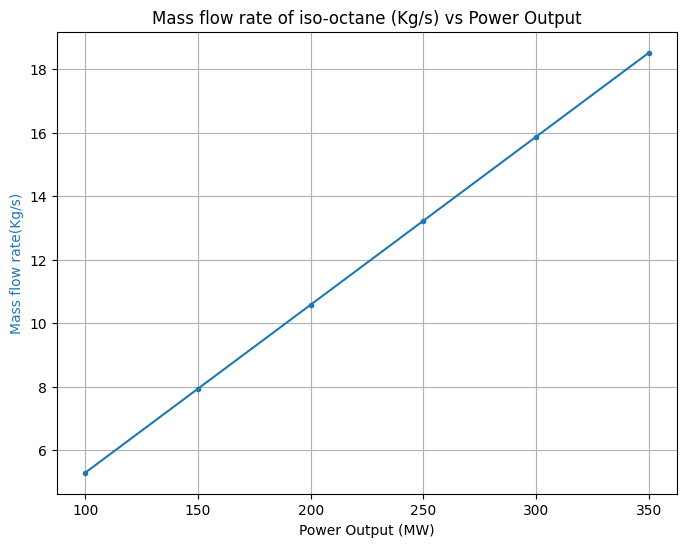

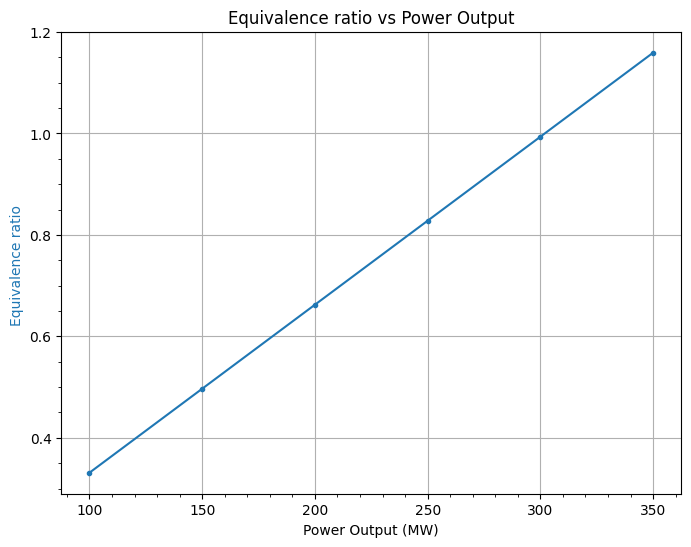

In [163]:
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(Power_output,  total_mass_iso_octane, '.-', color='C0')
plt.title('Mass flow rate of iso-octane (Kg/s) vs Power Output')
plt.grid()
plt.xlabel('Power Output (MW)')
plt.ylabel('Mass flow rate(Kg/s)', color='C0')
#f.tight_layout()
plt.show()

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(Power_output,  phi_overall, '.-', color='C0')
plt.title('Equivalence ratio vs Power Output')
plt.grid(True)
plt.minorticks_on()
plt.xlabel('Power Output (MW)')
plt.ylabel('Equivalence ratio ', color='C0')
#f.tight_layout()
plt.show()

In [164]:
# residense time calculation

residence_time_actual = np.zeros(len(Power_output))
for i in range(len(Power_output)):
      
    T_initial = 800    # K
    P_initial = 30    # atm

    #Create a gas object using the Jerzembeck mechanism
    gas = ct.Solution('Jerzembeck.yaml')

    gas.TP = T_initial, P_initial*ct.one_atm
    gas.set_equivalence_ratio(phi_overall[i], 'IXC8H18', 'O2:12.5, N2:47')

    # Create a reservoir for the inlet
    inlet = ct.Reservoir(gas)
    gas.equilibrate('HP')

    combustor = ct.IdealGasReactor(gas)
    combustor.volume = Combustor_volume

    # Create a reservoir for the exhaust
    exhaust = ct.Reservoir(gas)

    # Use a variable mass flow rate to keep the residence time in the reactor
    # constant (residence_time = mass / mass_flow_rate). The mass flow rate function
    # can access variables defined in the calling scope, including state variables
    # of the Reactor object (combustor) itself.


    def mdot(t):
        return combustor.mass / residence_time


    inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

    # A PressureController has a baseline mass flow rate matching the 'primary'
    # MassFlowController, with an additional pressure-dependent term. By explicitly
    # including the upstream mass flow rate, the pressure is kept constant without
    # needing to use a large value for 'K', which can introduce undesired stiffness.
    outlet_mfc = ct.PressureController(combustor, exhaust, primary=inlet_mfc, K=0.01)

    # the simulation only contains one reactor
    sim = ct.ReactorNet([combustor])

    # Run a loop over decreasing residence times, until the reactor is extinguished,
    # saving the state after each iteration.
    states = ct.SolutionArray(gas, extra=['tres'])

    residence_time = 0.1  # starting residence time
    while combustor.T > 800:
        sim.initial_time = 0.0  # reset the integrator
        sim.advance_to_steady_state()
        #print('tres = {:.2e}; T = {:.1f}'.format(residence_time, combustor.T))
        states.append(combustor.thermo.state, tres=residence_time)
        residence_time *= 0.9  # decrease the residence time for the next iteration
    print(residence_time)
   
    residence_time_actual[i] = residence_time
#residence_time_actual[0] = 5.39e-04
print(residence_time_actual)

0.00046383976865881093
2.427494450315474e-05
6.170365191715195e-06
2.9512665430652833e-06
1.9363259789051326e-06
1.7426933810146194e-06
[4.63839769e-04 2.42749445e-05 6.17036519e-06 2.95126654e-06
 1.93632598e-06 1.74269338e-06]


In [157]:
print(phi_overall)

[0.33117284 0.49675926 0.66234568 0.8279321  0.99351852 1.15910494]


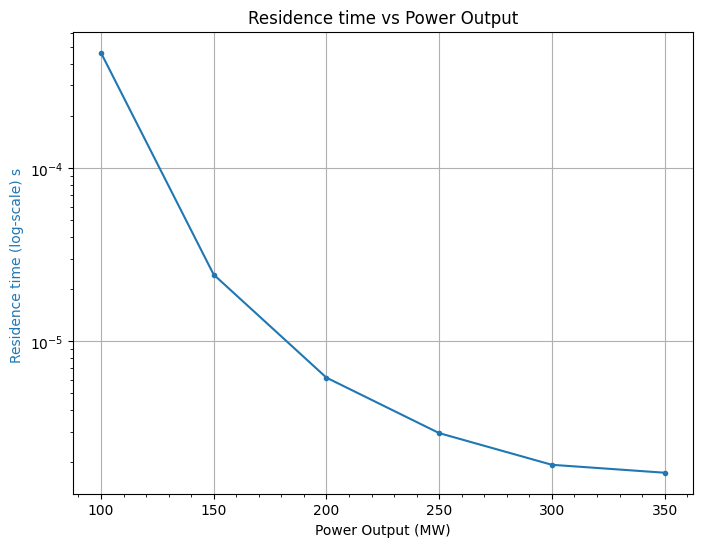

In [165]:
# Plot results
plt.figure(figsize=(8, 6))
plt.semilogy(Power_output,  residence_time_actual, '.-', color='C0')
plt.title('Residence time vs Power Output')
plt.grid(True)
plt.minorticks_on()
plt.xlabel('Power Output (MW)')
plt.ylabel('Residence time (log-scale) s ', color='C0')
#f.tight_layout()
plt.show()

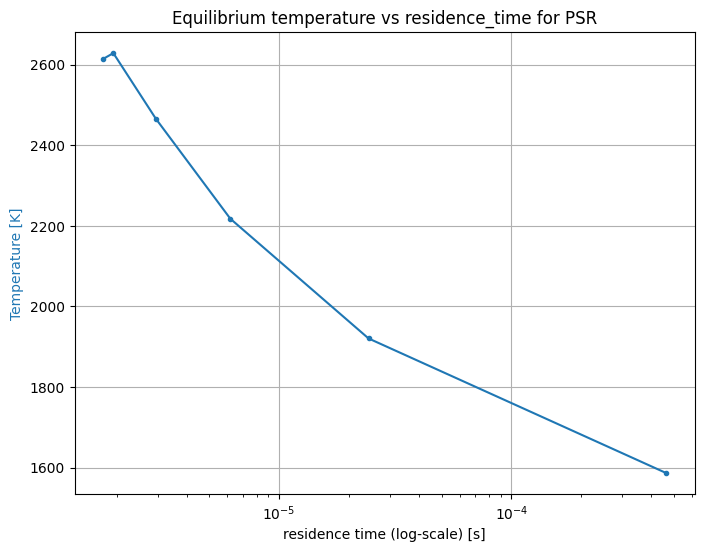

In [159]:
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(residence_time_actual,  equilibrium_temperature_actual, '.-', color='C0')
plt.title('Equilibrium temperature vs residence_time for PSR')
plt.grid()
plt.xscale('log')
plt.xlabel('residence time (log-scale) [s]')
plt.ylabel('Temperature [K]', color='C0')
plt.show()

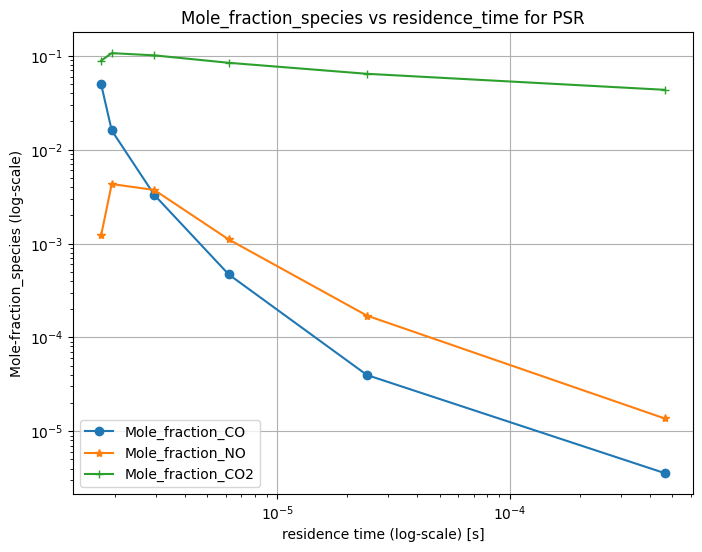

In [166]:
# Plot results
plt.figure(figsize=(8, 6))
# Plot results
plt.plot(residence_time_actual, mole_fraction_CO, label = 'Mole_fraction_CO', marker = 'o')
plt.plot(residence_time_actual, mole_fraction_NO,  label = 'Mole_fraction_NO', marker = '*')
plt.plot(residence_time_actual, mole_fraction_CO2, label = 'Mole_fraction_CO2', marker = '+')
plt.title('Mole_fraction_species vs residence_time for PSR')
plt.grid()
# Set the x-axis and y-axis to a logarithmic scale
plt.xscale('log')
plt.yscale('log')
plt.xlabel('residence time (log-scale) [s]')
plt.ylabel('Mole-fraction_species (log-scale)')
plt.legend()
plt.show()